In [1]:
# Imports
import pickle
import numpy as np
import pandas as pd
import nltk
import string
import re
import seaborn
from nltk.stem.porter import *
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt


## Load helper functions and pickled files

In [2]:
# Helper functions

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    #tokens = re.split("[^a-zA-Z]*", tweet.lower())
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

def get_pos_tags(tweets):
    """Takes a list of strings (tweets) and
    returns a list of strings of (POS tags).
    """
    tweet_tags = []
    for t in tweets:
        tokens = basic_tokenize(preprocess(t))
        tags = nltk.pos_tag(tokens)
        tag_list = [x[1] for x in tags]
        #for i in range(0, len(tokens)):
        tag_str = " ".join(tag_list)
        tweet_tags.append(tag_str)
    return tweet_tags

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features_(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features.

    This is modified to only include those features in the final
    model."""

    sentiment = sentiment_analyzer.polarity_scores(tweet)

    words = preprocess(tweet) #Get text only

    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    twitter_objs = count_twitter_objs(tweet) #Count #, @, and http://
    features = [FKRA, FRE, syllables, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['compound'],
                twitter_objs[2], twitter_objs[1],]
    #features = pandas.DataFrame(features)
    return features

def get_oth_features(tweets):
    """Takes a list of tweets, generates features for
    each tweet, and returns a numpy array of tweet x features"""
    feats=[]
    for t in tweets:
        feats.append(other_features_(t))
    return np.array(feats)

In [3]:
# Load final model files
print "Loading trained classifier... "
model = joblib.load('classifier/final_model.pkl')

print "Loading other information..."
tf_vectorizer = joblib.load('classifier/final_tfidf.pkl')
idf_vector = joblib.load('classifier/final_idf.pkl')
pos_vectorizer = joblib.load('classifier/final_pos.pkl')   

Loading trained classifier... 
Loading other information...


C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.18 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Preprocess the data

In [4]:
df = pd.read_pickle("data/labeled_data.p")
tweets = df.tweet

In [5]:
fixed_tweets = []
for i, t_orig in enumerate(tweets):
    s = t_orig
    try:
        s = s.encode("latin1")
    except:
        try:
            s = s.encode("utf-8")
        except:
            pass
    if type(s) != unicode:
        fixed_tweets.append(unicode(s, errors="ignore"))
    else:
        fixed_tweets.append(s)
assert len(tweets) == len(fixed_tweets), "shouldn't remove any tweets"
tweets = fixed_tweets
print len(tweets), " tweets to classify"

24783  tweets to classify


### Build features

In [6]:
stemmer = PorterStemmer()
sentiment_analyzer = VS()

tf_array = tf_vectorizer.fit_transform(tweets).toarray()
tfidf_array = tf_array*idf_vector
print "Built TF-IDF array"

pos_tags = get_pos_tags(tweets)
pos_array = pos_vectorizer.fit_transform(pos_tags).toarray()
print "Built POS array"

oth_array = get_oth_features(tweets)
print "Built other feature array"

M = np.concatenate([tfidf_array, pos_array, oth_array],axis=1)
M = pd.DataFrame(M)

C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\feature_extraction\text.py:1577: UserWarning: Only (<type 'numpy.float64'>, <type 'numpy.float32'>, <type 'numpy.float16'>) 'dtype' should be used. <type 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)
C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'abov', u'ani', u'becaus', u'befor', u'doe', u'dure', u'ha', u'hi', u'onc', u'onli', u'ourselv', u'themselv', u'thi', u'veri', u'wa', u'whi', u'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Built TF-IDF array
Built POS array
Built other feature array


## Run model

In [7]:
print "Running classification model..."

predicted_class = model.predict(M)

Running classification model...


In [8]:
y = df['class'].astype(int)

In [9]:
report = classification_report(y, predicted_class)
print(report)

              precision    recall  f1-score   support

           0       0.42      0.60      0.50      1430
           1       0.97      0.91      0.94     19190
           2       0.83      0.95      0.88      4163

   micro avg       0.90      0.90      0.90     24783
   macro avg       0.74      0.82      0.77     24783
weighted avg       0.91      0.90      0.90     24783



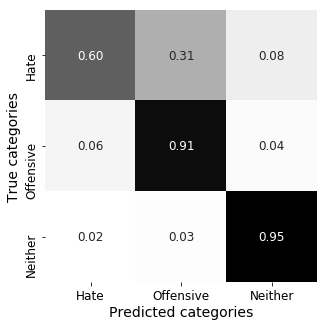

In [10]:
confusion_matrix = confusion_matrix(y,predicted_class)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)